In [17]:
library(Seurat)

kwak_ptpms=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms) = kwak_ptpms$X
kwak_ptpms[,1] =NULL
colnames(kwak_ptpms) = c("sec_ptms", "res_ptms", "av_ptms")

In [18]:
all_intd_sct = readRDS("../data/intd_seu_objects/intd_normalized_etc_11_12_20_30pcs_p7_res_kwak_cor.rds")

In [19]:
AZ_seu = subset(x = all_intd_sct, idents =  "14")

In [20]:
WT_AZ_seu = subset(x = AZ_seu, subset = orig.geno ==  "WT")

In [21]:
mut_AZ_seu = subset(x = AZ_seu, subset = orig.geno ==  "MUT")

In [ ]:
DefaultAssay(WT_AZ_seu ) <- "RNA"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering

WT_AZ_seu <- NormalizeData(WT_AZ_seu)
WT_AZ_seu <- FindVariableFeatures(WT_AZ_seu, selection.method = "vst", nfeatures = 2000)
WT_AZ_seu <- ScaleData(WT_AZ_seu, verbose = FALSE)
WT_AZ_seu  <- RunPCA(WT_AZ_seu , npcs = 30, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

WT_AZ_seu  <- FindNeighbors(WT_AZ_seu , dims = 1:30)
WT_AZ_seu  <- FindClusters(WT_AZ_seu , resolution = 0.5)
WT_AZ_seu  <- RunUMAP(WT_AZ_seu , reduction = "pca", dims = 1:30)

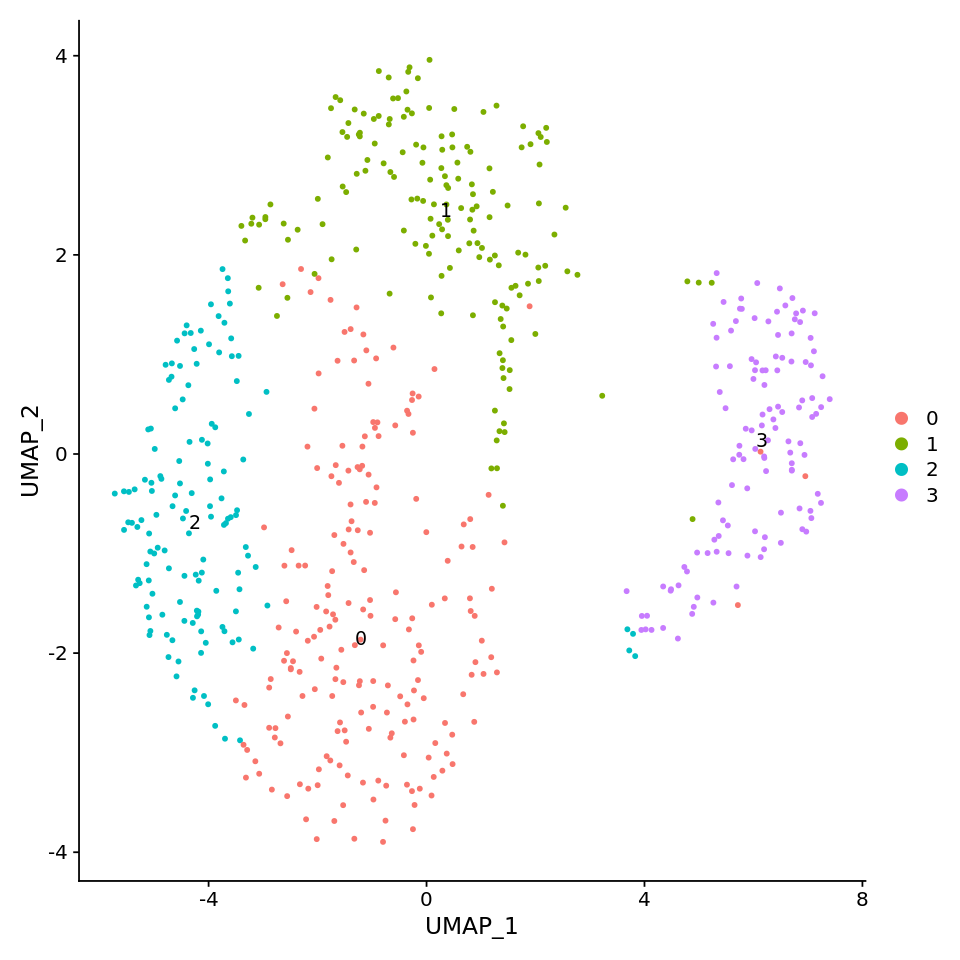

In [8]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(WT_AZ_seu, reduction = "umap", label = TRUE)

In [ ]:
DefaultAssay(WT_AZ_seu ) <- "RNA"
FeaturePlot(WT_AZ_seu, features = c("AT5G44568"),  pt.size = 1.5, order = TRUE, )#, slot = "data")
FeaturePlot(WT_AZ_seu, features = c("AT5G65710"),  pt.size = 1.5, order = TRUE, min = 1, )#, slot = "data")
FeaturePlot(WT_AZ_seu, features = c("AT1G68765"),  pt.size = 2, order = TRUE, )#, slot = "data")
FeaturePlot(WT_AZ_seu, features = c("AT1G63700"),  pt.size = 1.5, order = TRUE, min = 1, )#, slot = "data")
FeaturePlot(WT_AZ_seu, features = c("AT1G51660"),  pt.size = 1.5, order = TRUE, min = 1, )
FeaturePlot(WT_AZ_seu, features = c("AT3G21220"),  pt.size = 1.5, order = TRUE, min = 1,)
FeaturePlot(WT_AZ_seu, features = c("AT3G45640"),  pt.size = 1.5, order = TRUE, min = 1, )
FeaturePlot(WT_AZ_seu, features = c("AT2G43790"),  pt.size = 1.5, order = TRUE, min = 1, )
FeaturePlot(WT_AZ_seu, features = c("AT2G41850"),  pt.size = 1.5, order = TRUE, min = 1, )
FeaturePlot(WT_AZ_seu, features = c("AT3G07970"),  pt.size = 1.5, order = TRUE, min = 1, )

In [12]:
#get pseudobulk for each cluster to compare with kwak data
pbs = list()
count = 1
for (l in levels(WT_AZ_seu@meta.data$seurat_clusters)) {
    pbs[[count]] = rowSums(as.matrix(GetAssayData(subset(WT_AZ_seu, subset = orig.geno == "WT"), slot = "counts")[, WhichCells(subset(WT_AZ_seu, subset = orig.geno == "WT"), ident = l)])) 
    count = count + 1
}

#saveRDS(pbs, "../data/counts/cluster_pbs_11_12_20")

In [13]:
#convert pseudobulk to TPM
count = 1
for (c in pbs) {
    pbs[[count]] = data.frame(c)/sum(data.frame(c))*1000000
    colnames(pbs[[count]])= "counts"
    count = count + 1
}

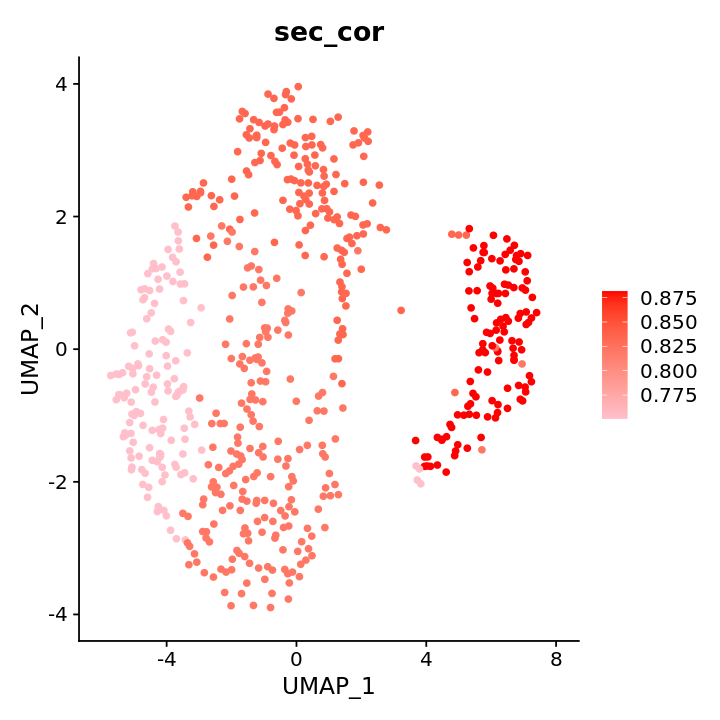

In [36]:
#WT secession cell correlation
cors_spearman = vector()
count = 1
for (cluster in c(1:4)){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),], kwak_ptpms[intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),1])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

options(repr.plot.width=6, repr.plot.height=6)

for (i in c(1:4)){
    WT_AZ_seu@meta.data$sec_cor[WT_AZ_seu@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

FeaturePlot(WT_AZ_seu,  features = "sec_cor", pt.size = 1.5, cols = c("pink", "red"))

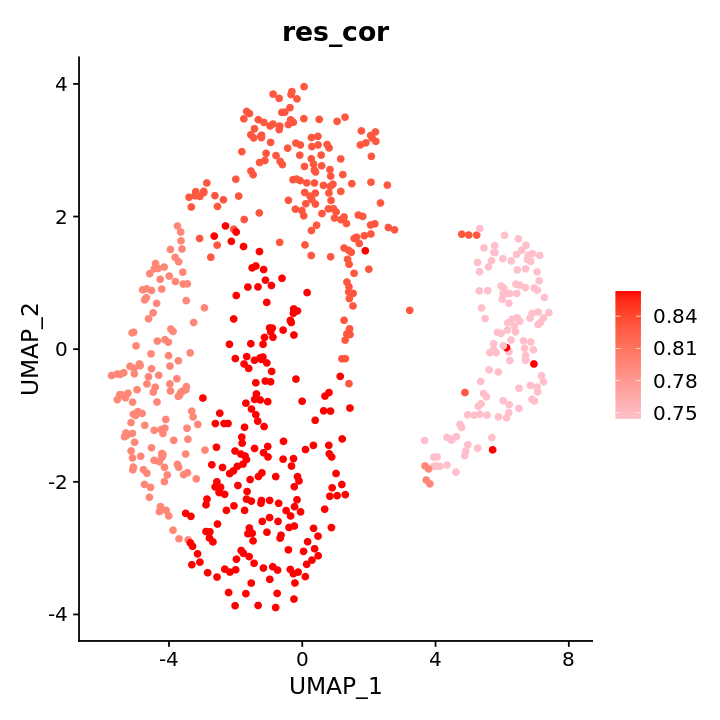

In [37]:
#WT residuum cell correlation
cors_spearman = vector()
count = 1
for (cluster in c(1:4)){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),], kwak_ptpms[intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),2])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

options(repr.plot.width=6, repr.plot.height=6)

for (i in c(1:4)){
    WT_AZ_seu@meta.data$res_cor[WT_AZ_seu@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

FeaturePlot(WT_AZ_seu,  features = "res_cor", pt.size = 1.5, cols = c("pink", "red"))

In [ ]:
#Mutant
DefaultAssay(mut_AZ_seu ) <- "RNA"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering

mut_AZ_seu <- NormalizeData(mut_AZ_seu)
mut_AZ_seu <- FindVariableFeatures(mut_AZ_seu, selection.method = "vst", nfeatures = 2000)
mut_AZ_seu <- ScaleData(mut_AZ_seu, verbose = FALSE)
mut_AZ_seu  <- RunPCA(mut_AZ_seu , npcs = 30, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

mut_AZ_seu  <- FindNeighbors(mut_AZ_seu , dims = 1:30)
mut_AZ_seu  <- FindClusters(mut_AZ_seu , resolution = 0.5)
mut_AZ_seu  <- RunUMAP(mut_AZ_seu , reduction = "pca", dims = 1:30)


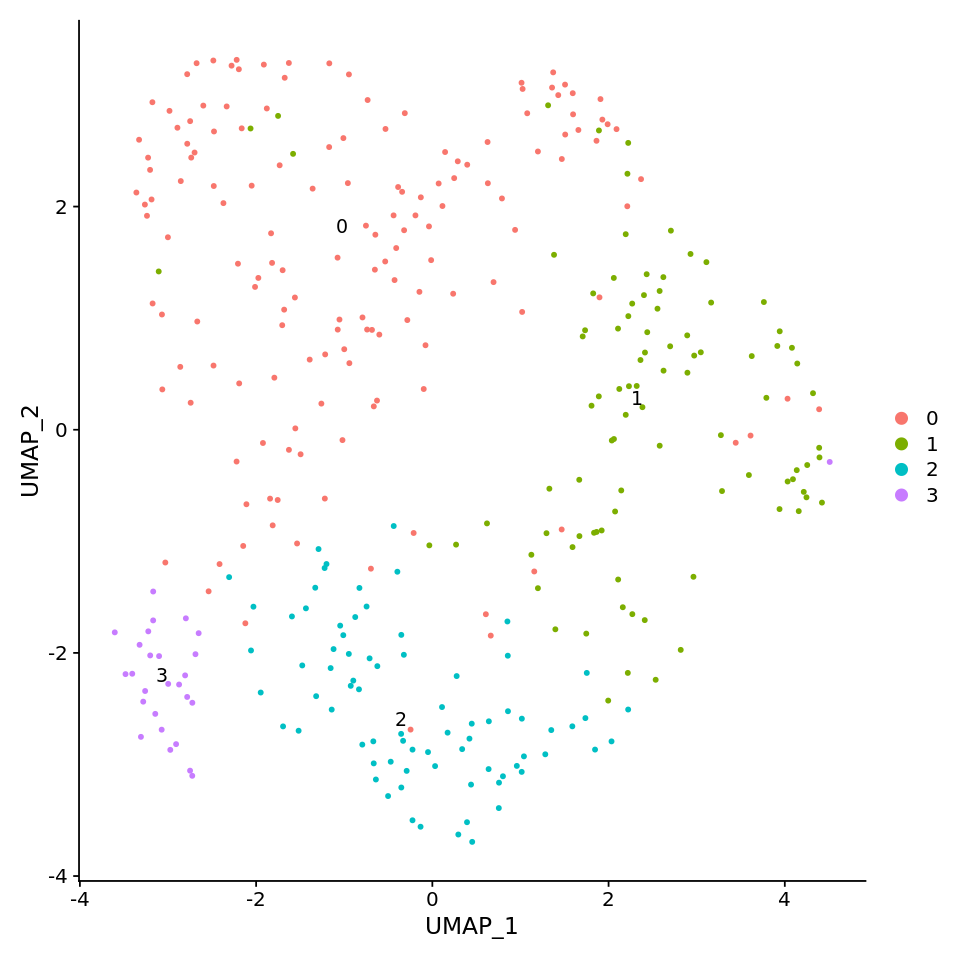

In [40]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(mut_AZ_seu, reduction = "umap", label = TRUE)

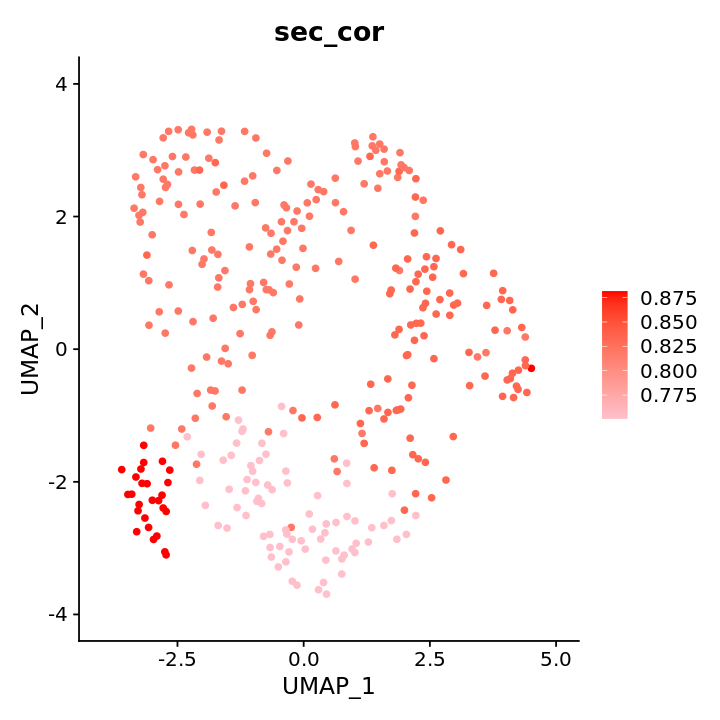

In [38]:
#mutant secession cell correlation
cors_spearman = vector()
count = 1
for (cluster in c(1:4)){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),], kwak_ptpms[intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),1])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

options(repr.plot.width=6, repr.plot.height=6)

for (i in c(1:4)){
    mut_AZ_seu@meta.data$sec_cor[mut_AZ_seu@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

FeaturePlot(mut_AZ_seu,  features = "sec_cor", pt.size = 1.5, cols = c("pink", "red"))

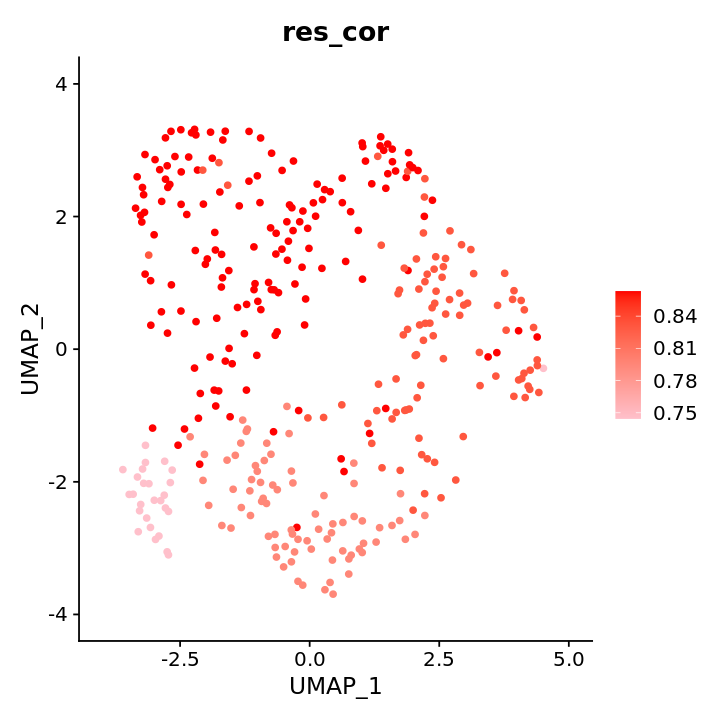

In [42]:
#mutant residuum cell correlation
cors_spearman = vector()
count = 1
for (cluster in c(1:4)){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),], kwak_ptpms[intersect(rownames(pbs[[cluster]]), rownames(kwak_ptpms)),2])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

options(repr.plot.width=6, repr.plot.height=6)

for (i in c(1:4)){
    mut_AZ_seu@meta.data$res_cor[mut_AZ_seu@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

FeaturePlot(mut_AZ_seu,  features = "res_cor", pt.size = 1.5, cols = c("pink", "red"))

In [ ]:
DefaultAssay(AZ_seu ) <- "RNA"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering

AZ_seu <- NormalizeData(AZ_seu)
AZ_seu <- FindVariableFeatures(AZ_seu, selection.method = "vst", nfeatures = 2000)
AZ_seu <- ScaleData(AZ_seu, verbose = FALSE)
AZ_seu  <- RunPCA(AZ_seu , npcs = 30, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

AZ_seu  <- FindNeighbors(AZ_seu , dims = 1:30)
AZ_seu  <- FindClusters(AZ_seu , resolution = 0.5)
AZ_seu  <- RunUMAP(AZ_seu , reduction = "pca", dims = 1:30)

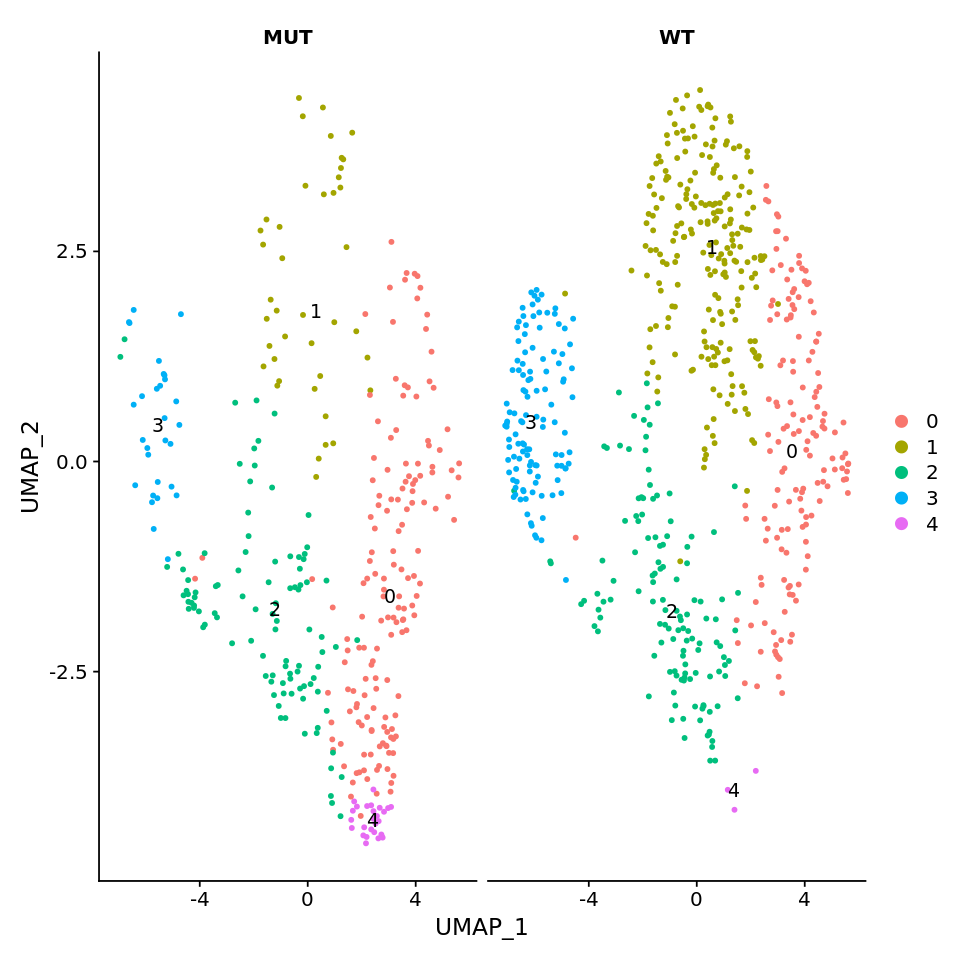

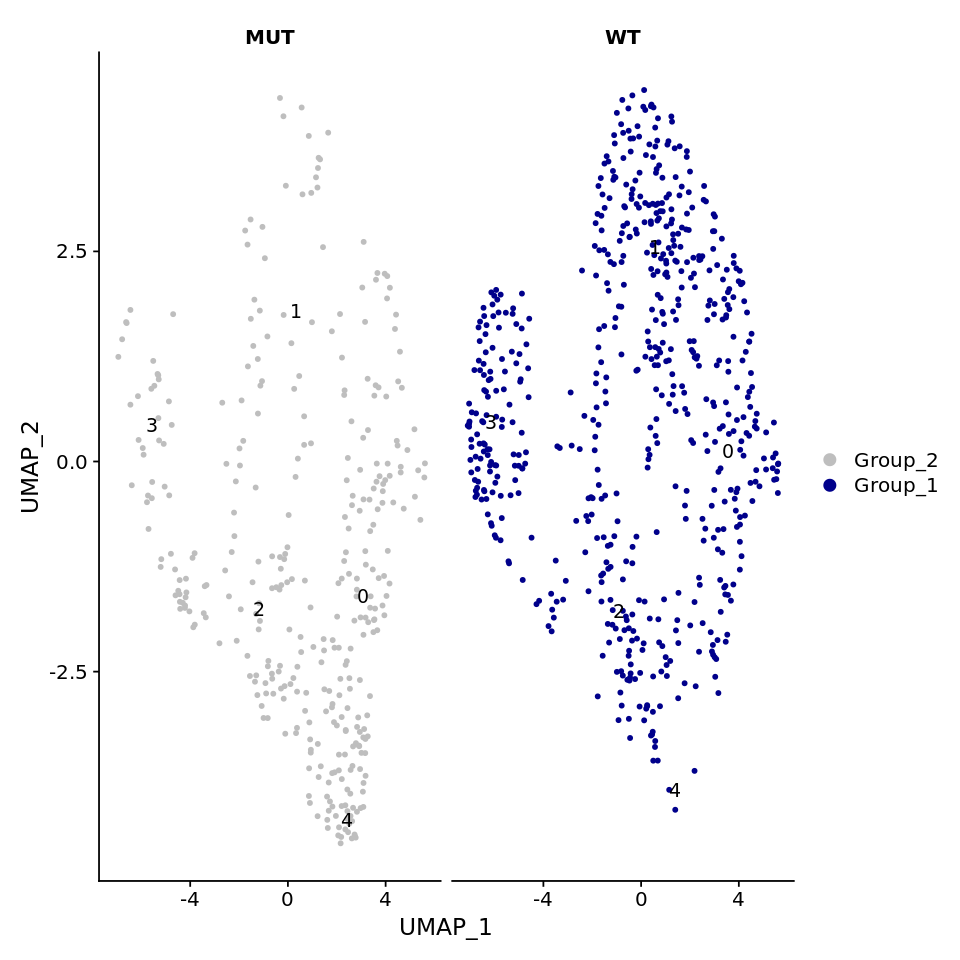

In [37]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(AZ_seu, reduction = "umap", label = TRUE, split.by = "orig.geno")
WT <- WhichCells(subset(AZ_seu, subset = orig.geno == "WT"))
MUT <- WhichCells(subset(AZ_seu, subset = orig.geno == "MUT"))
DimPlot(AZ_seu, label=T, split.by= "orig.geno",cells.highlight= list(WT, MUT), cols.highlight = c("darkblue", "darkred"), cols= "grey")

In [35]:
AZ_seu@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,percent.mito,percent.cp,nCount_SCT,nFeature_SCT,integrated_snn_res.0.5,seurat_clusters,orig.geno,kwak_cor,integrated_snn_res.0.7,kwak_cors_cells,RNA_snn_res.0.5
,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>,<chr>,<dbl>,<fct>,<dbl>,<fct>
AAACCCACATCCGTGG_1,WT_1,8118,2925,1.1456024,0.3572308,6900,2925,9,1,WT,0.8962291,14,0.4540782,1
AAACGAAAGCGATGCA_1,WT_1,20248,4968,0.6222837,0.5531411,6398,2546,9,2,WT,0.8962291,14,0.4862804,2
AAAGAACCAGAGATGC_1,WT_1,9088,3391,1.3534331,0.4731514,6999,3390,9,2,WT,0.8962291,14,0.4142523,2
AAAGAACCATCCTCAC_1,WT_1,9877,3470,0.9517060,0.4049813,6984,3447,9,2,WT,0.8962291,14,0.4058971,2
AAAGGTAAGGACTGGT_1,WT_1,6573,2852,1.0345352,0.9432527,6466,2851,9,1,WT,0.8962291,14,0.3874314,1
AACAGGGTCTCAGTCC_1,WT_1,18159,4791,2.6433174,0.3304147,6464,2722,9,1,WT,0.8962291,14,0.5117379,1
AACCAACGTTTGGGAG_1,WT_1,12340,4123,1.0372771,0.9805511,7196,3673,9,2,WT,0.8962291,14,0.4195951,2
AACCATGAGTTGCATC_1,WT_1,7508,2771,0.4262120,0.5460842,6724,2770,9,1,WT,0.8962291,14,0.4451153,1
AACCATGTCGATTGGT_1,WT_1,18475,5140,0.5250338,0.6332882,6300,2743,9,1,WT,0.8962291,14,0.5119701,1
